In [41]:
# Collect all data from .json file, output METHODS_COUNT, TEST_METHOD_MAP, DISCREPANT_TEST_METHOD_MAP. 
import json

from matplotlib import pyplot as plt
import numpy as np

TOTAL_TESTS = 0
DISCREPANT_TESTS = 0
DISCREPANT_METHODS = []
METHODS_COUNT = {}
TEST_METHOD_MAP = {}
DISCREPANT_TEST_METHOD_MAP = {}

def get_methods_from_file(file_path):
    
    with open(file_path, "r") as f:
        methods = f.read().splitlines()

    return methods



def find_tests_with_methods(methods_json_path, methods, app_name):
    global DISCREPANT_TESTS
    global TOTAL_TESTS
    global METHODS_COUNT
    global TEST_METHOD_MAP
    global DISCREPANT_METHODS
    
    with open(methods_json_path, "r") as f:
        json_data = json.load(f)

    tests = json_data.keys()

    app_tests = 0
    for i in tests:
        if not json_data[i] == []: # remove tests with no cloud methods
            app_tests += 1

    tests_with_methods = []
    test_methods_count = {}
    discrepant_methods = []
    test_methods_map = {}
    for key, value in json_data.items():
        for i in value:
            if i in test_methods_count:
                test_methods_count[i] += 1
            else:
                test_methods_count[i] = 1
        for method in methods:
            if method in value:
                # print(method)
                if not method in discrepant_methods:
                    discrepant_methods.append(method)
                if not key in tests_with_methods:
                    tests_with_methods.append(key)

                if not method in DISCREPANT_METHODS:
                    DISCREPANT_METHODS.append(method)
                
                if not key in TEST_METHOD_MAP:
                    TEST_METHOD_MAP[key] = [method]
                else:
                    TEST_METHOD_MAP[key].append(method)

                if not key in test_methods_map:
                    test_methods_map[key] = [method]
                else:
                    test_methods_map[key].append(method)
                # no need to check for other discrepant methods in this test hence break
                # break

    for i in test_methods_count:
        if i in METHODS_COUNT:
            METHODS_COUNT[i] += test_methods_count[i]
        else:
            METHODS_COUNT[i] = test_methods_count[i]

    print(f'Method counts: {json.dumps(test_methods_count, indent=2)}')
    print(f'Unique API methods: {len(test_methods_count)}')
    print(f'Discrepant Unique APIs: {len(discrepant_methods)}')
    print(f'Discrepant APIs: \n{[(i,test_methods_count[i]) for i in discrepant_methods]}')
    print(f'Potential discrepant tests: {len(tests_with_methods)}')
    print(f'Total tests: {app_tests}\n\n')

    DISCREPANT_TESTS += len(tests_with_methods)
    TOTAL_TESTS += app_tests
    test_methods_count = {k: v for k, v in test_methods_count.items() if k in DISCREPANT_METHODS}
    test_methods_count = {k: v for k, v in sorted(test_methods_count.items(), key=lambda item: item[1], reverse=True)}
    for i in test_methods_count.keys():
        if i in DISCREPANT_METHODS:
            for j in test_methods_map.keys():
                if i in test_methods_map[j]:
                    test_methods_map[j].pop(test_methods_map[j].index(i))
    return tests, tests_with_methods


def sum_methods_if_test_exists(traffic_json_path, discrepant_test_names):
  
    with open(traffic_json_path, "r") as f:
        traffic_data = json.load(f)

    cost = {
        "PUT": 0,
        "GET": 0,
        "POST": 0,
        "DELETE": 0,
        "PATCH": 0,
        "HEAD": 0,
        "OTHER": 0
    }

    for key, value in traffic_data.items():
        
        # run on cloud if discrepant test
        if key in discrepant_test_names:
            for request in cost:
                for key in value.keys():
                    cost[request] += value[key][request]

    return cost


# create an api popularity graph against discrepancies
def create_graph(x, y_line, y_bar, x_label, y_label, title):
    fig, ax_line = plt.subplots()
    ax_line.plot(x, y_line, 'r')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax_line.set_zorder(1)
    ax_line.patch.set_visible(False)
    ax_bar = plt.twinx()
    ax_bar.bar(x, y_bar)
    fig.set_zorder(ax_bar.get_zorder() + 1)
    plt.ylabel("Discrepant APIs Popularity")
    plt.title(title)
    plt.savefig("discrepant_api.pdf", format="pdf")
    plt.show()

    
def run_all_apps():

    global DISCREPANT_TESTS
    global TOTAL_TESTS

    apps = ['alpakka','orleans','identityazuretable','ironpigeon','sleet','attachmentplugin', 'insights', 'durabletask', 'streamstone']
    # apps = ['streamstone']
    methods_file_path = "discrepantApisEmulator.txt"
    methods = get_methods_from_file(methods_file_path)
    
    for j in apps:

        methods_json_path = f"application_sdk_methods/{j}.json"
        traffic_json_path = f"application_request_types/{j}.json"

        print(f'\nApp: {j} ----- Started\n\n')
        total_tests, discrepant_tests = find_tests_with_methods(methods_json_path, methods, j)

        # all tests on the cloud
        cloud_cost = sum_methods_if_test_exists(traffic_json_path, total_tests)
        total = 0
        print("*CLOUD COST*")
        for i in cloud_cost:
            print(i, cloud_cost[i])
            total += cloud_cost[i]
        print("Total: ", total)
        print()

        # a combination of cloud and emulator
        total = 0
        cloud_em_cost = sum_methods_if_test_exists(traffic_json_path, discrepant_tests)
        print("*CLOUD & EMULATOR COST*")
        for i in cloud_em_cost:
            print(i, cloud_em_cost[i])
            total += cloud_em_cost[i]
        print("Total: ", total)
        print()

        total = 0
        print("*SAVINGS*")
        for i in range(len(cloud_cost)):
            saving = cloud_cost[list(cloud_cost.keys())[i]] - cloud_em_cost[list(cloud_em_cost.keys())[i]]
            print(list(cloud_cost.keys())[i], saving)
            total += saving
        print("Total: ", total)
        print('\n----------------------------------------------\n')

    print("Total tests: ", TOTAL_TESTS)
    print("Potential discrepant tests: ", DISCREPANT_TESTS)


if __name__ == "__main__":

    run_all_apps()


App: alpakka ----- Started


Method counts: {
  "Queue_Create": 9,
  "Messages_Enqueue": 7,
  "Messages_Dequeue": 8,
  "Queue_Delete": 9,
  "MessageId_Delete": 1,
  "Messages_Peek": 1
}
Unique API methods: 6
Discrepant Unique APIs: 2
Discrepant APIs: 
[('Queue_Delete', 9), ('Messages_Peek', 1)]
Potential discrepant tests: 9
Total tests: 9


*CLOUD COST*
PUT 12
GET 17
POST 129
DELETE 15
PATCH 0
HEAD 0
OTHER 0
Total:  173

*CLOUD & EMULATOR COST*
PUT 12
GET 17
POST 129
DELETE 15
PATCH 0
HEAD 0
OTHER 0
Total:  173

*SAVINGS*
PUT 0
GET 0
POST 0
DELETE 0
PATCH 0
HEAD 0
OTHER 0
Total:  0

----------------------------------------------


App: orleans ----- Started


Method counts: {
  "Table_Create": 151,
  "Table_QueryEntities": 117,
  "Table_MergeEntity": 33,
  "Table_DeleteEntity": 19,
  "Table_QueryEntitiesWithPartitionAndRowKey": 118,
  "Table_Batch": 98,
  "Table_InsertEntity": 107,
  "Queue_Create": 73,
  "Messages_Dequeue": 72,
  "Table_UpdateEntity": 46,
  "Messages_Enqueue": 47,
  

In [42]:
import pandas as pd
METHODS_COUNT = {k: v for k, v in sorted(METHODS_COUNT.items(), key=lambda item: item[1], reverse=True)}
while len(METHODS_COUNT) < 105:
    METHODS_COUNT[f'place_holder_{len(METHODS_COUNT)}'] = 0
df_pop = pd.DataFrame({
    'API': METHODS_COUNT.keys(),
    'Popularity': METHODS_COUNT.values(),
})


In [43]:
# Discrepant APIs rank
discrepand_method_sorted = []
for method in METHODS_COUNT:
    if method in DISCREPANT_METHODS:
        discrepand_method_sorted.append((method, METHODS_COUNT[method]))
print("Discrepant API ranking: ")
discrepand_method_sorted

Discrepant API ranking: 


[('Table_Delete', 286),
 ('BlockBlob_Upload', 190),
 ('Queue_Delete', 157),
 ('Container_Delete', 142),
 ('Blob_AcquireLease', 128),
 ('Container_AcquireLease', 96),
 ('Container_ListBlobFlatSegment', 92),
 ('Service_ListContainersSegment', 52),
 ('Container_SetAccessPolicy', 8),
 ('Messages_Peek', 6),
 ('Container_ListBlobHierarchySegment', 2),
 ('Blob_ChangeLease', 2)]

In [44]:
df_pop

,API,Popularity
0,Table_Create,511
1,Table_QueryEntities,454
2,Table_InsertEntity,373
3,Table_Delete,286
4,Table_Batch,282
...,...,...
100,place_holder_100,0
101,place_holder_101,0
102,place_holder_102,0
103,place_holder_103,0


In [45]:
# color array for bar graph
bar_color = ['red' if x in DISCREPANT_METHODS else 'cornflowerblue' for x in METHODS_COUNT]
colors = {'Discrepant API':'red', 'Non-discrepant API':'deepskyblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

/var/folders/fy/x_86p0r53zl9w0cqtc30w4fh0000gn/T/ipykernel_14858/975196656.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pop_plt = sns.barplot(df_pop, x = df_pop.index, y = 'Popularity', palette=bar_color)


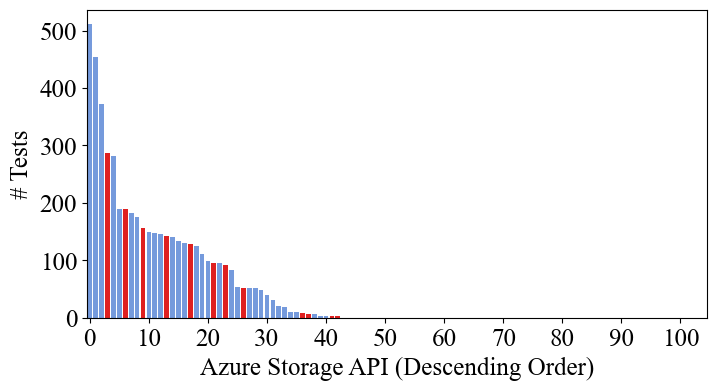

In [46]:
import seaborn as sns, matplotlib as plt
pop_plt = sns.barplot(df_pop, x = df_pop.index, y = 'Popularity', palette=bar_color)
pop_plt.set_xlabel("Azure Storage API (Descending Order)")
pop_plt.set_ylabel("# Tests")
pop_plt.set_xticks(range(0, len(df_pop), 10))
pop_plt.figure.set_size_inches(8, 4)
plt.rcParams.update({'font.size': 18, 'font.family': "Times New Roman"})


In [18]:
pop_plt.figure.savefig("azure_api_tests.pdf", format='pdf', bbox_inches = "tight")

In [47]:
# Rerun data collection
run_all_apps()



App: alpakka ----- Started


Method counts: {
  "Queue_Create": 9,
  "Messages_Enqueue": 7,
  "Messages_Dequeue": 8,
  "Queue_Delete": 9,
  "MessageId_Delete": 1,
  "Messages_Peek": 1
}
Unique API methods: 6
Discrepant Unique APIs: 2
Discrepant APIs: 
[('Queue_Delete', 9), ('Messages_Peek', 1)]
Potential discrepant tests: 9
Total tests: 9


*CLOUD COST*
PUT 12
GET 17
POST 129
DELETE 15
PATCH 0
HEAD 0
OTHER 0
Total:  173

*CLOUD & EMULATOR COST*
PUT 12
GET 17
POST 129
DELETE 15
PATCH 0
HEAD 0
OTHER 0
Total:  173

*SAVINGS*
PUT 0
GET 0
POST 0
DELETE 0
PATCH 0
HEAD 0
OTHER 0
Total:  0

----------------------------------------------


App: orleans ----- Started


Method counts: {
  "Table_Create": 151,
  "Table_QueryEntities": 117,
  "Table_MergeEntity": 33,
  "Table_DeleteEntity": 19,
  "Table_QueryEntitiesWithPartitionAndRowKey": 118,
  "Table_Batch": 98,
  "Table_InsertEntity": 107,
  "Queue_Create": 73,
  "Messages_Dequeue": 72,
  "Table_UpdateEntity": 46,
  "Messages_Enqueue": 47,
  

In [48]:
# Extract fixed tests after fixing the top5 discrepant APIs
fix_count = {k: v for k, v in METHODS_COUNT.items() if k in DISCREPANT_METHODS}
fix_count = {k: v for k, v in sorted(fix_count.items(), key=lambda item: item[1], reverse=True)}
fix_count_test_map = TEST_METHOD_MAP.copy()
temp_dict = {}
for test in fix_count_test_map.keys():
    for method in fix_count_test_map[test]:
        if method in DISCREPANT_METHODS:
            temp_dict[test] = fix_count_test_map[test].copy()
            continue
fix_count_test_map = temp_dict


fixed_tests = set() # Store fixed_test.
counter = 0
for i in fix_count.keys():
    if i in DISCREPANT_METHODS:
        for j in fix_count_test_map.keys():
            while i in fix_count_test_map[j]:
                fix_count_test_map[j].pop(fix_count_test_map[j].index(i))
            if counter <= 6 and fix_count_test_map[j] == []:
                fixed_tests.add(j)
    counter += 1
    if counter == 5: #break after 5 fixes
        break


In [49]:
# Load discrepant results (Azure only)
discrepant_result_dict = {
  'durabletask': ['DeleteTaskHub',
  'TestInstanceAndMessageDistribution',
  'CreateTaskHub',
  'MultiWorkerLeaseMovement',
  'MonitorIdleTaskHubDisconnected',
  'UpdateTaskHubJsonWithNewPartitionCount',
  'MonitorIncreasingControlQueueLoadDisconnected',
  'HelloWorldOrchestration_Inline',
  'HelloWorldOrchestration_Activity',
  'SequentialOrchestration',
  'SequentialOrchestrationNoReplay',
  'ParentOfSequentialOrchestration',
  'LongRunningOrchestrator',
  'GetAllOrchestrationStatuses',
  'GetPaginatedStatuses',
  'GetInstanceIdsByPrefix',
  'NoInstancesGetAllOrchestrationStatusesNullContinuationToken',
  'EventConversation',
  'AutoStart',
  'ContinueAsNewThenTimer',
  'PurgeInstanceHistoryForSingleInstanceWithoutLargeMessageBlobs',
  'ValidateCustomStatusPersists',
  'ValidateNullCustomStatusPersists',
  'PurgeInstanceHistoryForSingleInstanceWithLargeMessageBlobs',
  'ParallelOrchestration',
  'LargeFanOutOrchestration',
  'FanOutOrchestration_LargeHistoryBatches',
  'ActorOrchestration',
  'ActorOrchestrationForLargeInput',
  'ActorOrchestrationDeleteAllLargeMessageBlobs',
  'TerminateOrchestration',
  'SuspendResumeOrchestration',
  'TerminateSuspendedOrchestration',
  'RewindOrchestrationsFail',
  'RewindActivityFailFanOut',
  'RewindActivityFail',
  'RewindMultipleActivityFail',
  'RewindSubOrchestrationsTest',
  'RewindSubOrchestrationActivityTest',
  'RewindNestedSubOrchestrationTest',
  'TimerCancellation',
  'TimerExpiration',
  'OrchestrationConcurrency',
  'HandledActivityException',
  'UnhandledOrchestrationException',
  'UnhandledActivityException',
  'FanOutToTableStorage',
  'SmallTextMessagePayloads',
  'LargeTableTextMessagePayloads_SizeViolation_BlobUrl',
  'LargeOverallTextMessagePayloads_BlobUrl',
  'LargeTextMessagePayloads_FetchLargeMessages',
  'LargeTableTextMessagePayloads_FetchLargeMessages',
  'TagsAreAvailableInOrchestrationState',
  'LargeOrchestrationTags',
  'NonBlobUriPayload_FetchLargeMessages_RetainsOriginalPayload',
  'LargeTextMessagePayloads_FetchLargeMessages_QueryState',
  'LargeTextMessagePayloads_URIFormatCheck',
  'LargeBinaryByteMessagePayloads',
  'LargeBinaryStringMessagePayloads',
  'RecreateCompletedInstance',
  'RecreateFailedInstance',
  'RecreateTerminatedInstance',
  'RecreateRunningInstance',
  'ExtendedSessions_SessionTimeout',
  'DoubleFanOut',
  'AbortOrchestrationAndActivity',
  'ScheduledStart_Inline',
  'ScheduledStart_Activity_GetStatus_Returns_ScheduledStart',
  'TaskReturnsVoid_OrchestratorFails',
  'ConcurrentOrchestrationStarts',
  'RestartOrchestrationWithExternalEvents',
  'SingleOrchestratorWithSingleActivityAsync',
  'SingleOrchestrationWithThrowingExceptionAsync',
  'SingleOrchestratorWithMultipleActivitiesAsync',
  'SubOrchestratorAsync',
  'MultipleSubOrchestratorAsync',
  'SingleOrchestratorWithRetryAsync',
  'MultiLayeredOrchestrationWithRetryAsync',
  'ContinueAsNewAsync'],
 'alpakka': ['Akka.Streams.Azure.StorageQueue.Tests.QueueSinkSpec.A_QueueSink_should_add_elements_to_the_queue',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSinkSpec.A_QueueSink_should_retry_failing_messages_if_supervision_strategy_is_resume',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSourceSpecs.A_QueueSource_should_not_fail_if_the_supervision_strategy_is_not_stop_when_an_error_occurs',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSinkSpec.A_QueueSink_should_skip_failing_messages_if_supervision_strategy_is_restart',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSinkSpec.A_QueueSink_should_set_the_exception_of_the_task_when_an_error_occurs',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSourceSpecs.A_QueueSource_should_only_poll_if_demand_is_available',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSourceSpecs.A_QueueSource_should_poll_for_messages_if_the_queue_is_empty',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSourceSpecs.A_QueueSource_should_fail_when_an_error_occurs',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSourceSpecs.A_QueueSource_should_push_available_messages'],
 'streamstone': ['When_disabled']}
print("Discrepant results count:")
for k in discrepant_result_dict.keys():
    print(f"{k}: {len(discrepant_result_dict[k])}")

Discrepant results count:
durabletask: 79
alpakka: 9
streamstone: 1


In [50]:
# Find fixed discrepant results by intersection
fix_discrepant_result = {}
for k in discrepant_result_dict.keys():
    fix_discrepant_result[k] = []
    for test in discrepant_result_dict[k]:
        if test in fixed_tests:
            fix_discrepant_result[k].append(test)
print("Fixed discrepant results")
fix_discrepant_result

Fixed discrepant results


{'durabletask': [],
 'alpakka': ['Akka.Streams.Azure.StorageQueue.Tests.QueueSinkSpec.A_QueueSink_should_add_elements_to_the_queue',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSinkSpec.A_QueueSink_should_retry_failing_messages_if_supervision_strategy_is_resume',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSourceSpecs.A_QueueSource_should_not_fail_if_the_supervision_strategy_is_not_stop_when_an_error_occurs',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSinkSpec.A_QueueSink_should_skip_failing_messages_if_supervision_strategy_is_restart',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSinkSpec.A_QueueSink_should_set_the_exception_of_the_task_when_an_error_occurs',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSourceSpecs.A_QueueSource_should_poll_for_messages_if_the_queue_is_empty',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSourceSpecs.A_QueueSource_should_fail_when_an_error_occurs',
  'Akka.Streams.Azure.StorageQueue.Tests.QueueSourceSpecs.A_QueueSource_should_push_available_m

In [51]:
# Get total number of fixed discrepant results
fixed = 0
for k in fix_discrepant_result.keys():
    fixed += len(fix_discrepant_result[k])
print(f'Fixed discrepant result count: {fixed}')

Fixed discrepant result count: 9
